## DL-based Watermarking Approach (PixelSeal) - Multimedia Project
### Daniele Materia

In [1]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from torchvision import transforms
import videoseal

%matplotlib inline

# Setup device for notebook execution on Apple Silicon
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Load PixelSeal
print("Loading PixelSeal model...")
model = videoseal.load("pixelseal")
model = model.to(device)
model.eval()
print("Model loaded successfully!")

# Transformations
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

# File paths
SUBSET_DIR = Path("../images/test_subset")
test_images = sorted(list(SUBSET_DIR.glob("*.png")))
QUALITATIVE_EXAMPLE_INDEX = 14

objc[22446]: Class AVFFrameReceiver is implemented in both /opt/miniconda3/envs/multimedia_project_deep/lib/python3.10/site-packages/cv2/.dylibs/libavdevice.61.3.100.dylib (0x1127c83a8) and /opt/miniconda3/envs/multimedia_project_deep/lib/python3.10/site-packages/av/.dylibs/libavdevice.62.1.100.dylib (0x15bd643a8). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[22446]: Class AVFAudioReceiver is implemented in both /opt/miniconda3/envs/multimedia_project_deep/lib/python3.10/site-packages/cv2/.dylibs/libavdevice.61.3.100.dylib (0x1127c83f8) and /opt/miniconda3/envs/multimedia_project_deep/lib/python3.10/site-packages/av/.dylibs/libavdevice.62.1.100.dylib (0x15bd643f8). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.


Loading PixelSeal model...


/opt/miniconda3/envs/multimedia_project_deep/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


File /Users/danielemateria/Desktop/unict/LM-18/Multimedia/MM_Project/videoseal/ckpts/pixelseal_checkpoint.pth exists, skipping download
Model loaded successfully from /Users/danielemateria/Desktop/unict/LM-18/Multimedia/MM_Project/videoseal/ckpts/pixelseal_checkpoint.pth with message: <All keys matched successfully>
Model loaded successfully!


### DL-based Watermarking with PixelSeal

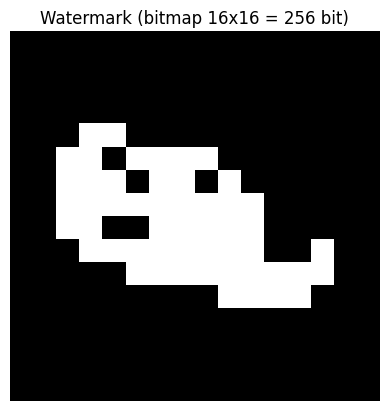

Watermark shape: (16, 16)
Payload shape: torch.Size([1, 256])


In [2]:
def create_binary_watermark(img_path, size):
    """
    Create a binary watermark image of shape (size, size) starting from an existing image.
    """
    watermark = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    watermark = cv2.resize(watermark, (size, size), interpolation=cv2.INTER_AREA)
    watermark = (watermark > 0).astype(np.uint8)
    return watermark

def prepare_payload(watermark_img):
    watermark_flat = watermark_img.flatten().astype(np.float32)
    return torch.from_numpy(watermark_flat).to(device).unsqueeze(0)


def embed_watermark_pixelseal(image, payload):
    """
    Embed the watermark in the image using PixelSeal.
    """
    img_tensor = to_tensor(image).unsqueeze(0).to(device)
    
    # Embedding
    with torch.no_grad():
        outputs = model.embed(img_tensor, payload)
    
    # Convert to numpy
    watermarked_tensor = outputs['imgs_w'][0]
    watermarked_image = to_pil(watermarked_tensor.cpu())
    watermarked_image = np.array(watermarked_image)
    
    return watermarked_image


def extract_watermark_pixelseal(watermarked_image, watermark_shape):
    """
    Extract the watermark using PixelSeal
    """
    img_tensor = to_tensor(watermarked_image).unsqueeze(0).to(device)
    
    # Watermark extraction (detection)
    with torch.no_grad():
        detected = model.detect(img_tensor)
    
    # Extract the bits not considering the first one (just a header)
    detected_preds = detected['preds'][0]
    detected_bits = (detected_preds[1:] > 0).float()
    
    # Back to the original shape
    extracted_watermark = detected_bits.cpu().numpy().reshape(watermark_shape)
    
    return extracted_watermark.astype(np.uint8)


class WatermarkingAttacks:
    @staticmethod
    def jpeg_compression(image, quality):
        encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
        _, encimg = cv2.imencode('.jpg', image, encode_param)
        return cv2.imdecode(encimg, 1)
    
    @staticmethod
    def gaussian_blur(image, kernel_size=3, sigma=1):
        return cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)
    
    @staticmethod
    def salt_and_pepper(image, amount=0.01):
        out = np.copy(image)
        # Salt noise
        num_salt = np.ceil(amount * image.size * 0.5)
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
        out[tuple(coords)] = 255
        # Pepper noise
        num_pepper = np.ceil(amount * image.size * 0.5)
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
        out[tuple(coords)] = 0
        return out


def calculate_psnr(im1, im2):
    """Compute PSNR between two images."""
    mse = np.mean((im1-im2)**2)
    psnr = 100 if mse == 0 else 20 * np.log10(255.0 / np.sqrt(mse))
    return psnr

def calculate_ber(img1, img2):
    """Compute Bit Error Rate between two binary images, with respect to the first image."""
    return np.sum(img1 != img2) / img1.size

# create watermark
watermark = create_binary_watermark('../images/unict_pittogramma_320x320.png', size=16)
payload = prepare_payload(watermark)

plt.imshow(watermark, cmap='gray')
plt.title("Watermark (bitmap 16x16 = 256 bit)")
plt.axis('off')
plt.show()

print(f"Watermark shape: {watermark.shape}")
print(f"Payload shape: {payload.shape}")

#### Qualitative example using PixelSeal, including attacks on watermark

/opt/miniconda3/envs/multimedia_project_deep/lib/python3.10/site-packages/torch/nn/functional.py:4077: UserWarning: The operator 'aten::_upsample_bilinear2d_aa.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  return torch._C._nn._upsample_bilinear2d_aa(input, output_size, align_corners, scale_factors)


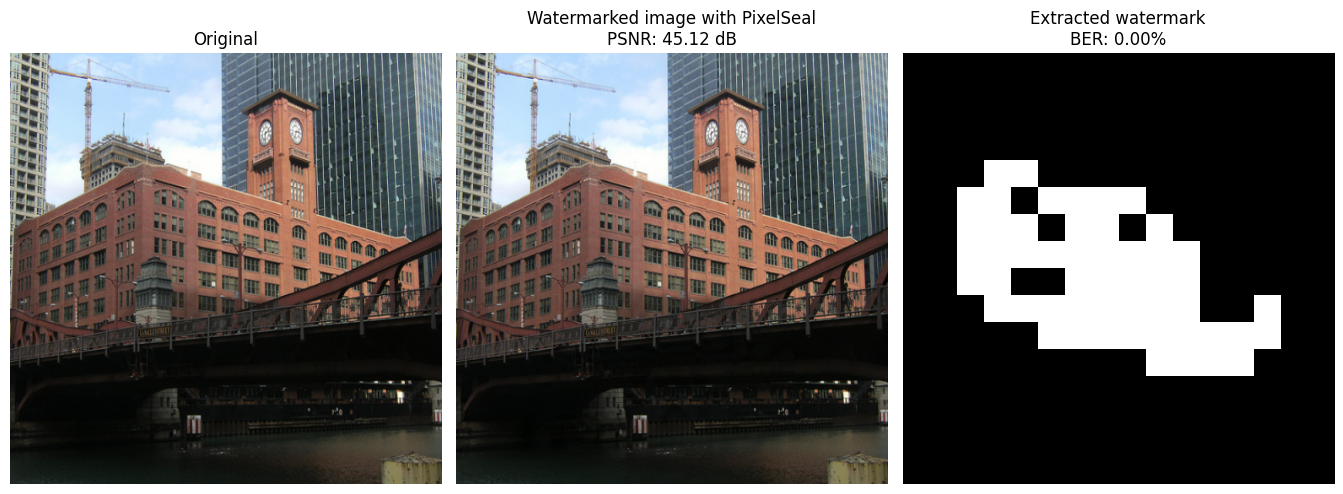

Attack to the watermark with JPEG compression


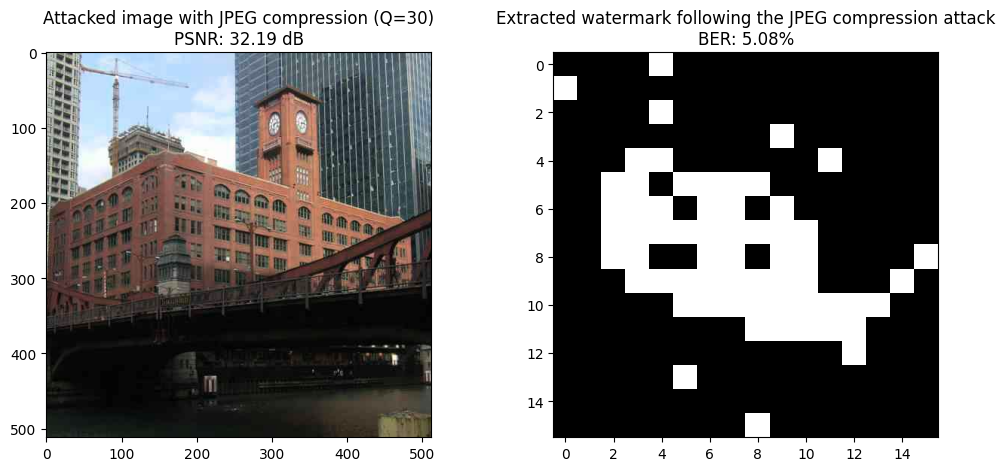

Attack to the watermark with Gaussian blur


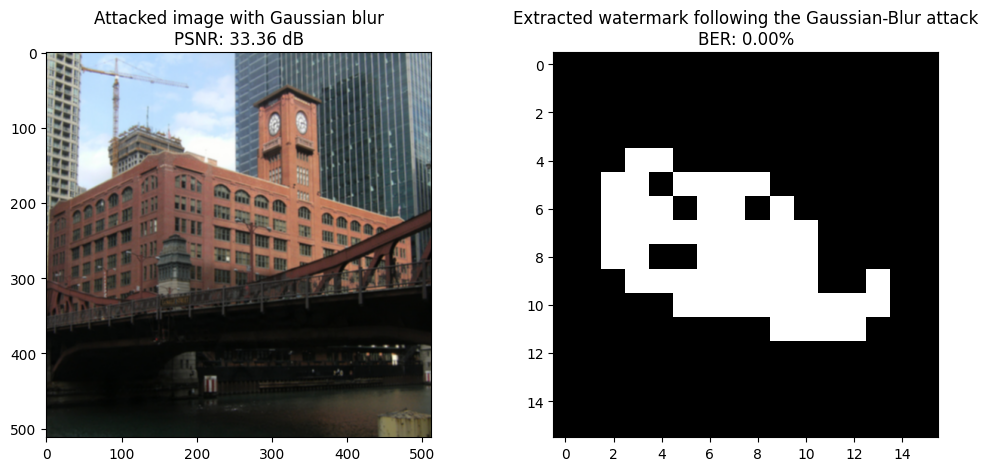

Attack to the watermark with Salt-Pepper noise


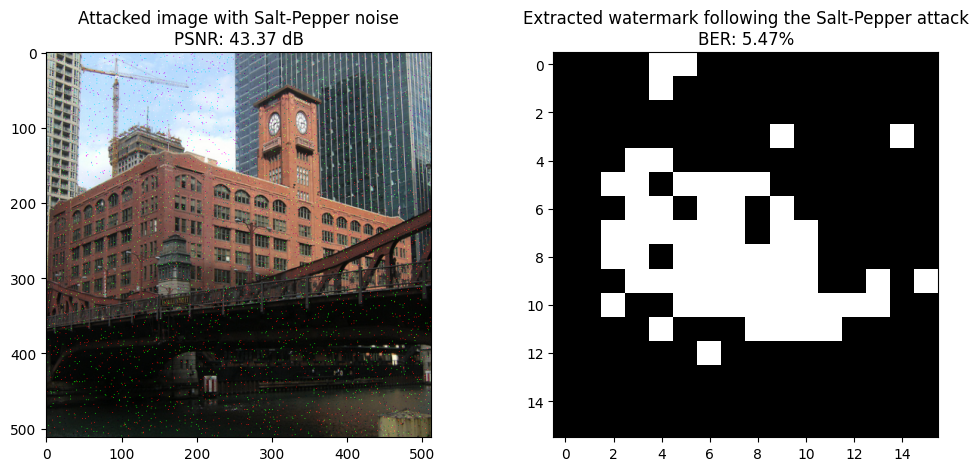

In [3]:
img_path = test_images[QUALITATIVE_EXAMPLE_INDEX]
img_bgr = cv2.imread(str(img_path))
img_orig = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Embedding and extraction
marked_image = embed_watermark_pixelseal(img_orig, payload)
extracted_watermark = extract_watermark_pixelseal(marked_image, watermark.shape)

# Compute evaluation metrics
ber = calculate_ber(watermark, extracted_watermark)
psnr = calculate_psnr(img_orig, marked_image)

plt.figure(figsize=(18, 6))
# Original
plt.subplot(141)
plt.title("Original")
plt.imshow(img_orig)
plt.axis('off')

# Watermarked
plt.subplot(142)
plt.title(f"Watermarked image with PixelSeal\nPSNR: {psnr:.2f} dB")
plt.imshow(marked_image)
plt.axis('off')

# Extracted watermark
plt.subplot(143)
plt.title(f"Extracted watermark\nBER: {ber:.2%}")
plt.imshow(extracted_watermark, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

# JPEG attack
print("Attack to the watermark with JPEG compression")
attacked_image_jpeg = WatermarkingAttacks.jpeg_compression(marked_image, quality=30)
extracted_after_attack_jpeg = extract_watermark_pixelseal(attacked_image_jpeg, watermark.shape)
ber_attacked_jpeg = calculate_ber(watermark, extracted_after_attack_jpeg)
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.title(f"Attacked image with JPEG compression (Q=30)\nPSNR: {calculate_psnr(img_orig, attacked_image_jpeg):.2f} dB")
plt.imshow(attacked_image_jpeg)
plt.subplot(122)
plt.title(f"Extracted watermark following the JPEG compression attack\nBER: {ber_attacked_jpeg:.2%}")
plt.imshow(extracted_after_attack_jpeg, cmap='gray')
plt.show()

# Gaussian Blur attack
print("Attack to the watermark with Gaussian blur")
attacked_image_gaussian = WatermarkingAttacks.gaussian_blur(marked_image)
extracted_after_attack_gaussian = extract_watermark_pixelseal(attacked_image_gaussian, watermark.shape)
ber_attacked_gaussian = calculate_ber(watermark, extracted_after_attack_gaussian)
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.title(f"Attacked image with Gaussian blur\nPSNR: {calculate_psnr(img_orig, attacked_image_gaussian):.2f} dB")
plt.imshow(attacked_image_gaussian)
plt.subplot(122)
plt.title(f"Extracted watermark following the Gaussian-Blur attack\nBER: {ber_attacked_gaussian:.2%}")
plt.imshow(extracted_after_attack_gaussian, cmap='gray')
plt.show()

# Salt-Pepper attack
print("Attack to the watermark with Salt-Pepper noise")
attacked_image_saltpepper = WatermarkingAttacks.salt_and_pepper(marked_image)
extracted_after_attack_saltpepper = extract_watermark_pixelseal(attacked_image_saltpepper, watermark.shape)
ber_attacked_saltpepper = calculate_ber(watermark, extracted_after_attack_saltpepper)
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.title(f"Attacked image with Salt-Pepper noise\nPSNR: {calculate_psnr(img_orig, attacked_image_saltpepper):.2f} dB")
plt.imshow(attacked_image_saltpepper)
plt.subplot(122)
plt.title(f"Extracted watermark following the Salt-Pepper attack\nBER: {ber_attacked_saltpepper:.2%}")
plt.imshow(extracted_after_attack_saltpepper, cmap='gray')
plt.show()

#### Full experiments on test set of 200 random images from COCO2017 Val (with attacks on watermark)

In [4]:
results_list_pixelseal = []
results_list_pixelseal_attacked = [[], [], []]  # 0: JPEG, 1: Gaussian, 2: Salt-Pepper

for i, img_path in enumerate(test_images):
    img_bgr = cv2.imread(str(img_path))
    img_orig = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    # Embedding and extraction
    marked_image = embed_watermark_pixelseal(img_orig, payload)
    extracted_watermark = extract_watermark_pixelseal(marked_image, watermark.shape)
    
    # Compute evaluation metrics
    ber = calculate_ber(watermark, extracted_watermark)
    psnr = calculate_psnr(img_orig, marked_image)
    
    results_list_pixelseal.append({
        "Image": img_path.name,
        "PSNR": psnr,
        "BER": ber
    })
    
    # Attacks
    # JPEG attack
    attacked_image = WatermarkingAttacks.jpeg_compression(marked_image, quality=30)
    extracted_after_attack = extract_watermark_pixelseal(attacked_image, watermark.shape)
    psnr_attacked = calculate_psnr(img_orig, attacked_image)
    ber_attacked = calculate_ber(watermark, extracted_after_attack)
    
    results_list_pixelseal_attacked[0].append({
        "Image": img_path.name,
        "PSNR": psnr_attacked,
        "BER": ber_attacked
    })
    
    # Gaussian blur
    attacked_image = WatermarkingAttacks.gaussian_blur(marked_image)
    extracted_after_attack = extract_watermark_pixelseal(attacked_image, watermark.shape)
    psnr_attacked = calculate_psnr(img_orig, attacked_image)
    ber_attacked = calculate_ber(watermark, extracted_after_attack)
    
    results_list_pixelseal_attacked[1].append({
        "Image": img_path.name,
        "PSNR": psnr_attacked,
        "BER": ber_attacked
    })
    
    # Salt-Pepper noise
    attacked_image = WatermarkingAttacks.salt_and_pepper(marked_image)
    extracted_after_attack = extract_watermark_pixelseal(attacked_image, watermark.shape)
    psnr_attacked = calculate_psnr(img_orig, attacked_image)
    ber_attacked = calculate_ber(watermark, extracted_after_attack)
    
    results_list_pixelseal_attacked[2].append({
        "Image": img_path.name,
        "PSNR": psnr_attacked,
        "BER": ber_attacked
    })
    

# Create final DataFrames and save .csv files
df_pixelseal = pd.DataFrame(results_list_pixelseal)
df_pixelseal.to_csv("../results/pixelseal_results.csv", index=False)

df_pixelseal_jpeg = pd.DataFrame(results_list_pixelseal_attacked[0])
df_pixelseal_jpeg.to_csv("../results/pixelseal_jpeg_attack_results.csv", index=False)

df_pixelseal_gaussian = pd.DataFrame(results_list_pixelseal_attacked[1])
df_pixelseal_gaussian.to_csv("../results/pixelseal_gaussian_attack_results.csv", index=False)

df_pixelseal_saltpepper = pd.DataFrame(results_list_pixelseal_attacked[2])
df_pixelseal_saltpepper.to_csv("../results/pixelseal_saltpepper_attack_results.csv", index=False)

print("PixelSeal statistics")
summary_stats_no_attacks = df_pixelseal[['PSNR', 'BER']].agg(['mean', 'std', 'min', 'max'])
summary_stats_jpeg = df_pixelseal_jpeg[['PSNR', 'BER']].agg(['mean', 'std', 'min', 'max'])
summary_stats_gaussian = df_pixelseal_gaussian[['PSNR', 'BER']].agg(['mean', 'std', 'min', 'max'])
summary_stats_saltpepper = df_pixelseal_saltpepper[['PSNR', 'BER']].agg(['mean', 'std', 'min', 'max'])

print("No Attacks")
display(summary_stats_no_attacks)
print("JPEG compression attack")
display(summary_stats_jpeg)
print("Gaussian blur attack")
display(summary_stats_gaussian)
print("Salt-Pepper noise attack")
display(summary_stats_saltpepper)

PixelSeal statistics
No Attacks


,PSNR,BER
mean,46.219403,0.000391
std,1.685013,0.001412
min,40.558436,0.000000
max,50.102843,0.007812


JPEG compression attack


,PSNR,BER
mean,33.160893,0.094355
std,1.557963,0.056277
min,29.812201,0.003906
max,38.230319,0.285156


Gaussian blur attack


,PSNR,BER
mean,35.440096,0.000645
std,2.558639,0.002101
min,30.110191,0.000000
max,42.534763,0.011719


Salt-Pepper noise attack


,PSNR,BER
mean,43.935857,0.127930
std,1.030871,0.061215
min,39.881445,0.015625
max,45.765603,0.324219
